In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
import sklearn as skt
import nltk
from nltk import sent_tokenize, word_tokenize
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
from collections import Counter
import re
import collections
from nltk.tokenize import RegexpTokenizer

# Loading the dataset

In [2]:
from google.colab import drive

# Monter Google Drive
drive.mount('/content/drive')

# Chemin vers le fichier dans Google Drive
file_path = '/content/drive/My Drive/ISOT Dataset/True.csv'

# Charger le fichier CSV
true_df = pd.read_csv(file_path)

# Vérification des premières lignes du dataframe
true_df.head()

Mounted at /content/drive


,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [3]:
# Chemin vers le fichier dans Google Drive
file_path = '/content/drive/My Drive/ISOT Dataset/Fake.csv'

# Charger le fichier CSV
fake_df = pd.read_csv(file_path)
fake_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


# Data Preprocessing

Preprocessing of true and fake datasets for data optimisation and removal of blank and duplicate entries.

## Verified News Dataset

In [4]:
# TRUE DATASET
# Checking for NaN values
true_df.isna().sum()

,0
title,0
text,0
subject,0
date,0


In [5]:
true_df['title']

,title
0,"As U.S. budget fight looms, Republicans flip t..."
1,U.S. military to accept transgender recruits o...
2,Senior U.S. Republican senator: 'Let Mr. Muell...
3,FBI Russia probe helped by Australian diplomat...
4,Trump wants Postal Service to charge 'much mor...
...,...
21412,'Fully committed' NATO backs new U.S. approach...
21413,LexisNexis withdrew two products from Chinese ...
21414,Minsk cultural hub becomes haven from authorities
21415,Vatican upbeat on possibility of Pope Francis ...


In [6]:
# Define function for most common words
# https://github.com/remydeshayes/NLP_Pytorch/blob/main/Notebook%20-%20Fake_News%20Detection%20Pytorch%20-%20Billiot_Deshayes.ipynb
from collections import Counter


def most_common(corpus, nb_words):
    articles = corpus.str.split()
    # Explanation of nested list comprehension:
    # Iterate through every article in articles
    # Iterate through every word in article (second for in loop)
    # Add word to the np.array if it is not a stopword (nltk)
    words = np.array([word for article in articles for word in article if word.lower() not in stopwords])
    counter = Counter(words)
    d = pd.DataFrame(counter, index=['occurences']).transpose().reset_index()
    d.columns = ['word', 'occurences']
    d = d.sort_values('occurences', ascending=False)
    return d[:nb_words]

In [7]:
# Download stopwords from nltk library
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = list(set(stopwords.words('english')))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
# This is VERY HIGH cpu compute (but it only takes a few seconds)
most_common(true_df['title'], 10)

,word,occurences
29,Trump,4400
0,U.S.,3872
45,says,2969
190,House,1360
522,North,905
38,White,788
69,Senate,720
22,Russia,718
523,Korea,695
135,Trump's,669


In [9]:
# Check for duplicates or blank articles
# Conversion to dataframe to reduce output text clutter
duplicate = true_df['title'].value_counts()[true_df['title'].value_counts()>1]
duplicate = duplicate.rename_axis('unique_values').reset_index(name='counts')
duplicate

,unique_values,counts
0,Factbox: Trump fills top jobs for his administ...,14
1,Factbox: Contenders for senior jobs in Trump's...,8
2,Highlights: The Trump presidency on April 13 a...,8
3,Factbox: International reaction to arrest of R...,6
4,Highlights: The Trump presidency on April 21 a...,5
...,...,...
528,Factbox: Key players in South Africa's ANC lea...,2
529,"Facebook, Google, Twitter asked to testify on ...",2
530,China says confident in economic relations wit...,2
531,'Fierce and formidable' Dlamini-Zuma eyes Sout...,2


In [10]:
# Number of duplicate entries
true_df['title'].value_counts()[true_df['title'].value_counts()>1].sum() - 212

912

In [11]:
# Deletion of duplicates
true_df = true_df.drop_duplicates(subset=['title'], ignore_index=True)

In [12]:
true_df.shape

(20826, 4)

For future EDA analysis, we keep the date column for plotting metrics. Date is processed into a uniform format.

In [13]:
true_df['date_len'] = [len(x) for x in true_df['date']]
print(true_df['date_len'].value_counts())
true_df = true_df.drop(['date_len'], axis=1)

date_len
17    6110
18    5608
19    2423
14    2004
16    1667
15    1610
13    1180
12     224
Name: count, dtype: int64


<ipython-input-13-2d5b7de3942a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  true_df['date_len'] = [len(x) for x in true_df['date']]


In [14]:
true_df

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"
...,...,...,...,...
20821,North Korea shipments to Syria chemical arms a...,UNITED NATIONS (Reuters) - Two North Korean sh...,worldnews,"August 21, 2017"
20822,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017"
20823,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017"
20824,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017"


In [15]:
from datetime import datetime

In [16]:
# All data format is uniform (month date, year)
# Unifying the date format to datetime
dates = []
for x in true_df['date']:
    date = datetime.strptime(x,'%B %d, %Y ')
    dates.append(date)
true_df['date'] = dates

In [17]:
true_df

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,2017-12-31
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,2017-12-29
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,2017-12-31
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,2017-12-30
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,2017-12-29
...,...,...,...,...
20821,North Korea shipments to Syria chemical arms a...,UNITED NATIONS (Reuters) - Two North Korean sh...,worldnews,2017-08-21
20822,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,2017-08-22
20823,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,2017-08-22
20824,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,2017-08-22


In [18]:
true_df['date_len'] = [len(str(x)) for x in true_df['date']]
print(true_df['date_len'].value_counts())
true_df = true_df.drop(['date_len'], axis=1)

date_len
19    20826
Name: count, dtype: int64


Finally creating a label variable - 1 means the news is verified

In [19]:
true_df['real'] = 1
true_df['fake'] = 0

In [20]:
true_df

,title,text,subject,date,real,fake
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,2017-12-31,1,0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,2017-12-29,1,0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,2017-12-31,1,0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,2017-12-30,1,0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,2017-12-29,1,0
...,...,...,...,...,...,...
20821,North Korea shipments to Syria chemical arms a...,UNITED NATIONS (Reuters) - Two North Korean sh...,worldnews,2017-08-21,1,0
20822,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,2017-08-22,1,0
20823,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,2017-08-22,1,0
20824,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,2017-08-22,1,0


## False News Dataset

We preprocess the articles in a similar manner as the true dataset

In [21]:
# FAKE DATASET
# Checking for NaN values
fake_df.isna().sum()

,0
title,0
text,0
subject,0
date,0


In [22]:
# Check for duplicates or blank articles
# Conversion to dataframe to reduce output textitlet clutter
duplicate = fake_df['title'].value_counts()[fake_df['title'].value_counts()>1]
duplicate = duplicate.rename_axis('unique_values').reset_index(name='counts')
duplicate

,unique_values,counts
0,MEDIA IGNORES Time That Bill Clinton FIRED His...,6
1,ELEMENTARY SCHOOL PLANS ‘BLACKS ONLY’ FIELD TR...,4
2,FORMER FBI ASST DIRECTOR: “Jim Comey ‘Danced W...,4
3,AN INSIDE LOOK AT OBAMA’S 5-STAR SUMMER VACATI...,3
4,"GARY JOHNSON: Meet The “Creepy” Pro-Amnesty, A...",3
...,...,...
5091,HUSBAND OF PRESIDENTIAL Candidate Under CRIMIN...,2
5092,#BlackLivesMatter Terrorists Using #BlackRail ...,2
5093,WATCH: SMARTPHONE CAPTURES NEW BOATLOAD OF “Sc...,2
5094,WATCH MAGA RALLY LIVE: President Trump Holds M...,2


In [23]:
fake_df['title'].value_counts()[fake_df['title'].value_counts()>1].sum() - 4927 - 626

5121

In [24]:
# Values with no text - only title
blank = fake_df.loc[fake_df["title"] == duplicate["unique_values"][0]]
blank

,title,text,subject,date
10919,MEDIA IGNORES Time That Bill Clinton FIRED His...,"In its 109-year history, only one F.B.I. direc...",politics,"May 10, 2017"
10920,MEDIA IGNORES Time That Bill Clinton FIRED His...,At the recommendation of both Attorney General...,politics,"May 10, 2017"
10924,MEDIA IGNORES Time That Bill Clinton FIRED His...,"In its 109-year history, only one F.B.I. direc...",politics,"May 10, 2017"
18650,MEDIA IGNORES Time That Bill Clinton FIRED His...,"In its 109-year history, only one F.B.I. direc...",left-news,"May 10, 2017"
18651,MEDIA IGNORES Time That Bill Clinton FIRED His...,At the recommendation of both Attorney General...,left-news,"May 10, 2017"
18654,MEDIA IGNORES Time That Bill Clinton FIRED His...,"In its 109-year history, only one F.B.I. direc...",left-news,"May 10, 2017"


In [25]:
blank.index

Index([10919, 10920, 10924, 18650, 18651, 18654], dtype='int64')

In [26]:
# Dropping the blank news from the fake dataframe
fake_df = fake_df.drop(blank.index)

In [27]:
# Verification of removal (verified)
fake_df

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016"
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016"
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016"
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016"


In [28]:
# Deletion of duplicates
fake_df = fake_df.drop_duplicates(subset=['title'], ignore_index=True)

In [29]:
fake_df

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
...,...,...,...,...
17897,The White House and The Theatrics of ‘Gun Cont...,21st Century Wire says All the world s a stage...,US_News,"January 7, 2016"
17898,Activists or Terrorists? How Media Controls an...,Randy Johnson 21st Century WireThe majority ...,US_News,"January 7, 2016"
17899,"BOILER ROOM – No Surrender, No Retreat, Heads ...",Tune in to the Alternate Current Radio Network...,US_News,"January 6, 2016"
17900,Federal Showdown Looms in Oregon After BLM Abu...,21st Century Wire says A new front has just op...,US_News,"January 4, 2016"


We process the date column once again

In [30]:
fake_df['date_len'] = [len(x) for x in fake_df['date']]
print(fake_df['date_len'].value_counts())

date_len
12     6806
11     2586
16     2020
13     1722
17     1634
14     1622
15     1020
18      451
9        35
145       1
88        1
149       1
74        1
66        1
120       1
Name: count, dtype: int64


<ipython-input-30-e96d43b97295>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fake_df['date_len'] = [len(x) for x in fake_df['date']]


In [31]:
fake_df.loc[fake_df["date_len"] > 18]

,title,text,subject,date,date_len
9357,https://100percentfedup.com/served-roy-moore-v...,https://100percentfedup.com/served-roy-moore-v...,politics,https://100percentfedup.com/served-roy-moore-v...,145
15499,https://100percentfedup.com/video-hillary-aske...,https://100percentfedup.com/video-hillary-aske...,politics,https://100percentfedup.com/video-hillary-aske...,88
15500,https://100percentfedup.com/12-yr-old-black-co...,https://100percentfedup.com/12-yr-old-black-co...,politics,https://100percentfedup.com/12-yr-old-black-co...,149
15830,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,politics,https://fedup.wpengine.com/wp-content/uploads/...,74
15831,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,politics,https://fedup.wpengine.com/wp-content/uploads/...,66
16554,Homepage,[vc_row][vc_column width= 1/1 ][td_block_trend...,left-news,MSNBC HOST Rudely Assumes Steel Worker Would N...,120


In [32]:
fake_df.loc[fake_df["date_len"] > 18].title

,title
9357,https://100percentfedup.com/served-roy-moore-v...
15499,https://100percentfedup.com/video-hillary-aske...
15500,https://100percentfedup.com/12-yr-old-black-co...
15830,https://fedup.wpengine.com/wp-content/uploads/...
15831,https://fedup.wpengine.com/wp-content/uploads/...
16554,Homepage


These are incorrect values for dates and they are not proper articles. So they will be dropped.

In [33]:
bad_date = fake_df.loc[fake_df["date_len"] > 18]

In [34]:
bad_date.index

Index([9357, 15499, 15500, 15830, 15831, 16554], dtype='int64')

In [35]:
# Dropping entries with bad date and no news from the fake dataframe
fake_df = fake_df.drop(index=bad_date.index)

In [36]:
# Verifying entries are dropped (verified)
fake_df

,title,text,subject,date,date_len
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",17
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",17
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",17
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",17
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",17
...,...,...,...,...,...
17897,The White House and The Theatrics of ‘Gun Cont...,21st Century Wire says All the world s a stage...,US_News,"January 7, 2016",15
17898,Activists or Terrorists? How Media Controls an...,Randy Johnson 21st Century WireThe majority ...,US_News,"January 7, 2016",15
17899,"BOILER ROOM – No Surrender, No Retreat, Heads ...",Tune in to the Alternate Current Radio Network...,US_News,"January 6, 2016",15
17900,Federal Showdown Looms in Oregon After BLM Abu...,21st Century Wire says A new front has just op...,US_News,"January 4, 2016",15


In [37]:
# All data format is uniform (month date, year)
# Unifying the date format to datetime
# Nested try except for ValueError exceptions in the fake dataset
dates = []
for x in fake_df['date']:
    try:
        date = datetime.strptime(x, '%B %d, %Y')
    except ValueError:
        try:
            date = datetime.strptime(x, '%d-%b-%y')
        except ValueError:
            date = datetime.strptime(x, '%b %d, %Y')
    dates.append(date)
fake_df['date'] = dates

In [38]:
# Verification
fake_df['date'].nunique

<bound method IndexOpsMixin.nunique of 0       2017-12-31
1       2017-12-31
2       2017-12-30
3       2017-12-29
4       2017-12-25
           ...    
17897   2016-01-07
17898   2016-01-07
17899   2016-01-06
17900   2016-01-04
17901   2016-01-02
Name: date, Length: 17896, dtype: datetime64[ns]>

All the dates are unique. Now the label for the fake dataset is finally added, where 0 means fake news

In [39]:
fake_df['real'] = 0
fake_df['fake'] = 1

In [40]:
fake_df = fake_df.drop(['date_len'], axis=1)
fake_df

,title,text,subject,date,real,fake
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,2017-12-31,0,1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,2017-12-31,0,1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,2017-12-30,0,1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,2017-12-29,0,1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,2017-12-25,0,1
...,...,...,...,...,...,...
17897,The White House and The Theatrics of ‘Gun Cont...,21st Century Wire says All the world s a stage...,US_News,2016-01-07,0,1
17898,Activists or Terrorists? How Media Controls an...,Randy Johnson 21st Century WireThe majority ...,US_News,2016-01-07,0,1
17899,"BOILER ROOM – No Surrender, No Retreat, Heads ...",Tune in to the Alternate Current Radio Network...,US_News,2016-01-06,0,1
17900,Federal Showdown Looms in Oregon After BLM Abu...,21st Century Wire says A new front has just op...,US_News,2016-01-04,0,1


Finally we concatenate both the dataframe

In [41]:
data = pd.concat([true_df, fake_df])
data = data.reset_index(drop=True)

In [42]:
data

,title,text,subject,date,real,fake
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,2017-12-31,1,0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,2017-12-29,1,0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,2017-12-31,1,0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,2017-12-30,1,0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,2017-12-29,1,0
...,...,...,...,...,...,...
38717,The White House and The Theatrics of ‘Gun Cont...,21st Century Wire says All the world s a stage...,US_News,2016-01-07,0,1
38718,Activists or Terrorists? How Media Controls an...,Randy Johnson 21st Century WireThe majority ...,US_News,2016-01-07,0,1
38719,"BOILER ROOM – No Surrender, No Retreat, Heads ...",Tune in to the Alternate Current Radio Network...,US_News,2016-01-06,0,1
38720,Federal Showdown Looms in Oregon After BLM Abu...,21st Century Wire says A new front has just op...,US_News,2016-01-04,0,1


In [43]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
%matplotlib inline

print("Number of words in dataset:", data['title'].apply(lambda x: len(x.split(' '))).sum())

Number of words in dataset: 472806


In [44]:
data.iloc[0,0:]

,0
title,"As U.S. budget fight looms, Republicans flip t..."
text,WASHINGTON (Reuters) - The head of a conservat...
subject,politicsNews
date,2017-12-31 00:00:00
real,1
fake,0


In [45]:
number_of_samples=data.iloc[:,0].count()

In [46]:
y=data.iloc[:,8:].sum(axis=1).value_counts()/data.iloc[:,0].count()*100

# Exploratory Data Analysis

In [47]:
# Importing matplotlib and seaborn
import matplotlib.pyplot as plt
import seaborn as sns

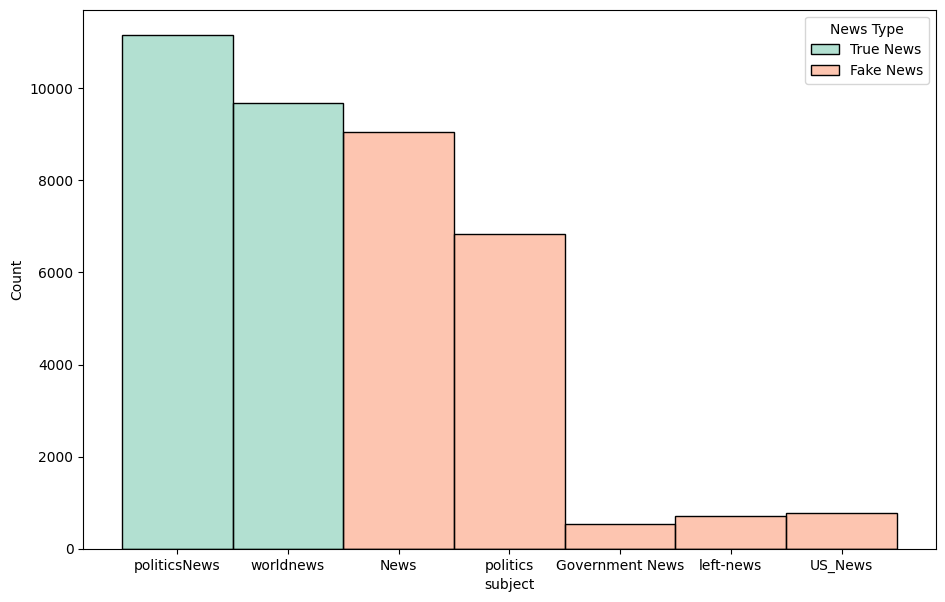

In [48]:
# Crée la figure et le graphique avec la palette de couleurs
fig, hist = plt.subplots(figsize=(11, 7))
colors = sns.color_palette("Set2", 2)

# Création du graphique avec la légende personnalisée
hist = sns.histplot(data=data, x='subject', hue='fake', palette=colors)

# Personnalisation de la légende pour afficher "True News" et "Fake News"
hist.legend_.set_title('News Type')
new_labels = ['True News', 'Fake News']
for t, l in zip(hist.legend_.texts, new_labels):
    t.set_text(l)

# Afficher le graphique
plt.show()


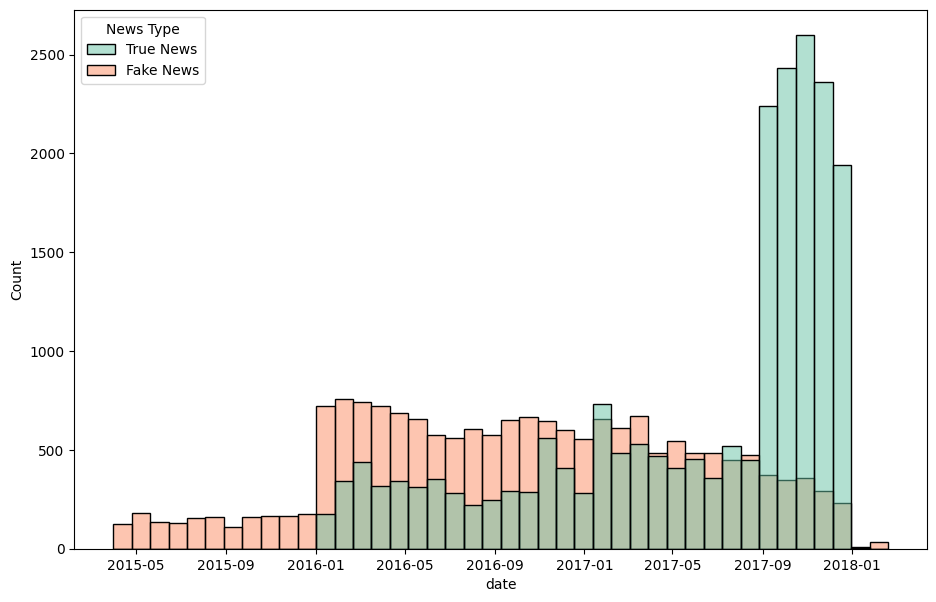

In [49]:
# Plotting histogram of article dates
fig, hist = plt.subplots(figsize=(11, 7))
colors = sns.color_palette("Set2", 2)

# Création du graphique avec la légende personnalisée
hist = sns.histplot(data=data, x = 'date', hue="fake", palette=colors)

# Personnalisation de la légende pour afficher "True News" et "Fake News"
hist.legend_.set_title('News Type')
new_labels = ['True News', 'Fake News']
for t, l in zip(hist.legend_.texts, new_labels):
    t.set_text(l)

# Afficher le graphique
plt.show()


The date distribution of verified and false articles are varying. Fake articles span from before 2016 and verified articles are recorded from after 2016. Also, most of the verified articles in the dataset seem to be dated between Sep 2017 to Jan 2018.
Date will not be taken into account.

<ipython-input-50-5b14143a0517>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar = sns.barplot(y='Average character length', x='Label', data=av, palette=colors)


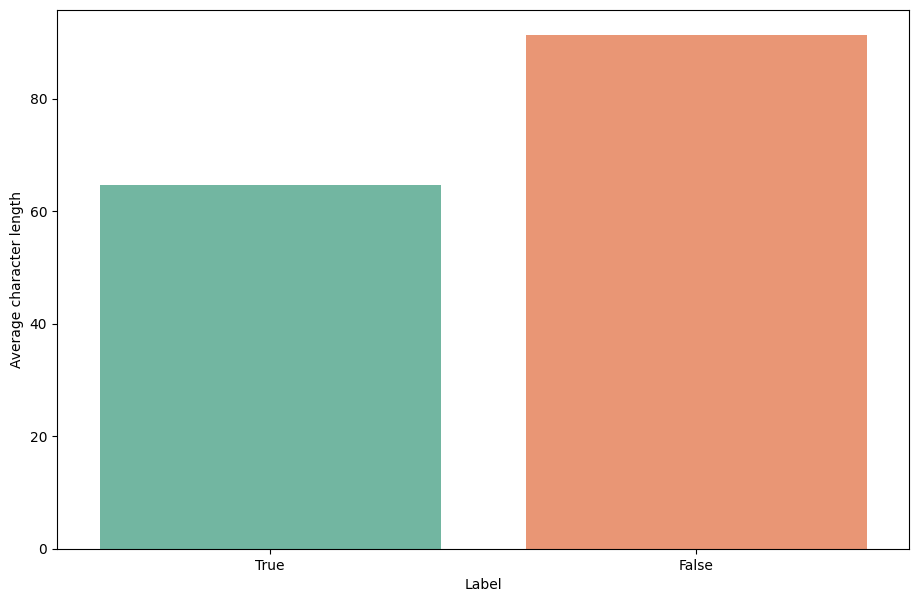

In [50]:
# Text analysis
av_t = data[data['real'] == 1]['title'].apply(lambda x: len(x)).mean()
av_f = data[data['fake'] == 1]['title'].apply(lambda x: len(x)).mean()
av = pd.DataFrame(data = {'Average character length': [av_t, av_f], 'Label':['True', 'False']})
fig, bar = plt.subplots(figsize = (11,7))

colors = sns.color_palette("Set2", 2)

bar = sns.barplot(y='Average character length', x='Label', data=av, palette=colors)

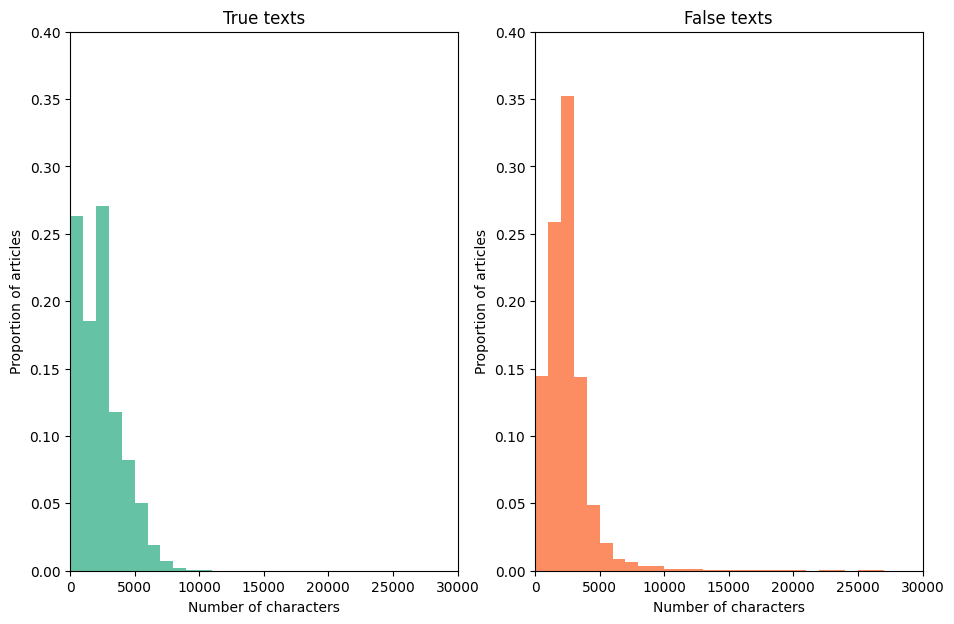

In [51]:
# Assuming you already have your data prepared
len_cha_true = data[data['real'] == 1]['text'].apply(lambda x: len(x))
len_cha_fake = data[data['fake'] == 1]['text'].apply(lambda x: len(x))

norm_weights_true = np.ones(len(len_cha_true)) / len(len_cha_true)
norm_weights_fake = np.ones(len(len_cha_fake)) / len(len_cha_fake)

bins = [i * 1000 for i in range(0, 31)]

# Define a color palette using Seaborn
colors = sns.color_palette("Set2", 10)

# Create subplots
fig, (hist1, hist2) = plt.subplots(1, 2, figsize=(11, 7))

# Use colors from the palette for the histograms
hist1.hist(len_cha_true, bins=bins, weights=norm_weights_true, color=colors[0])  # First color in the palette
hist1.set_ylim(0, 0.4)
hist1.set_xlim(0, 30000)
hist1.set_xlabel('Number of characters')
hist1.set_ylabel('Proportion of articles')
hist1.set_title('True texts')

hist2.hist(len_cha_fake, bins=bins, weights=norm_weights_fake, color=colors[1])  # Second color in the palette
hist2.set_ylim(0, 0.4)
hist2.set_xlim(0, 30000)
hist2.set_xlabel('Number of characters')
hist2.set_ylabel('Proportion of articles')
hist2.set_title('False texts')

# Display the plot
plt.show()


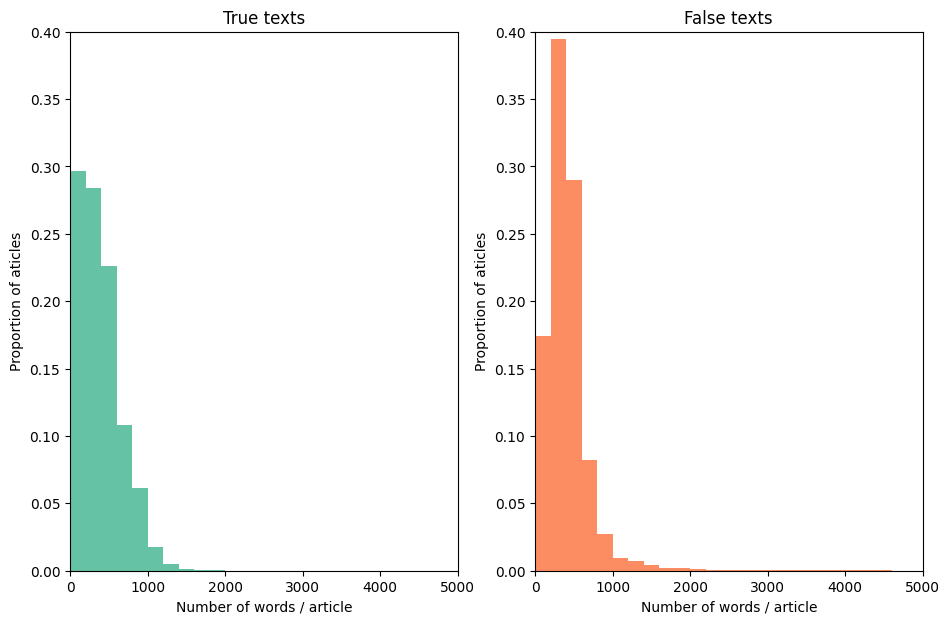

In [52]:
# Number of words per article
len_w_true = data[data['real'] == 1]['text'].str.split().map(lambda x: len(x))
len_w_fake = data[data['fake'] == 1]['text'].str.split().map(lambda x: len(x))

norm_weights_true = np.ones(len(len_w_true))/len(len_w_true)
norm_weights_fake = np.ones(len(len_w_fake))/len(len_w_fake)

bins_ = [i * 200 for i in range(0,26)]

# Define a color palette using Seaborn
colors = sns.color_palette("Set2", 10)

fig, (hist1, hist2) = plt.subplots(1,2, figsize = (11,7))
hist1.hist(len_w_true, bins = bins_, weights = norm_weights_true, color=colors[0])
hist1.set_ylim(0, top=0.4)
hist1.set_xlim(0, 5000)
hist1.set_xlabel('Number of words / article')
hist1.set_ylabel('Proportion of aticles')
hist1.set_title('True texts')
hist2.hist(len_w_fake, bins = bins_, weights = norm_weights_fake, color=colors[1])
hist2.set_ylim(0, top=0.4)
hist2.set_xlim(0, 5000)
hist2.set_xlabel('Number of words / article')
hist2.set_ylabel('Proportion of aticles')
hist2.set_title('False texts');

<ipython-input-53-0fb7dcd270ed>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(range(len(l0))), y=h0, ax=ax[0], palette=colors);
<ipython-input-53-0fb7dcd270ed>:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(range(len(l1))), y=h1, ax=ax[1], palette=colors);


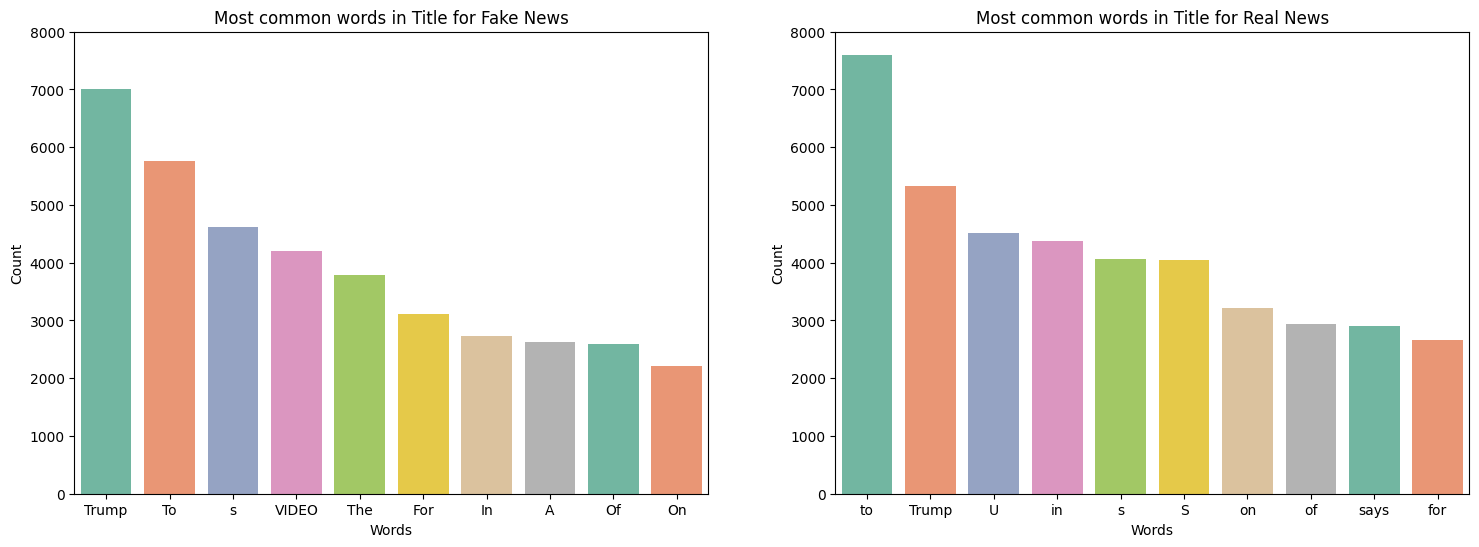

In [53]:

def get_wrd_count(text_lst):
    all_wrds = []
    tokenizer = RegexpTokenizer(r'\w+')
    for txt in text_lst:
        wrds = tokenizer.tokenize(txt)
        all_wrds.extend(wrds)
    wrd_counter = collections.Counter(all_wrds)
    return wrd_counter

fake_titles = data[data['fake']== 1]['title'].tolist()
real_titles = data[data['real']==1]['title'].tolist()

# word count

fake0_wrd = get_wrd_count(fake_titles)
real1_wrd = get_wrd_count(real_titles)

fake0_wrd_cnt_sorted = fake0_wrd.most_common(n=10)
real1_wrd_cnt_sorted = real1_wrd.most_common(n=10)
l0, h0, l1, h1 = [],[],[],[]
_ = [(l0.append(i[0]), h0.append(i[1])) for i in fake0_wrd_cnt_sorted]
_ = [(l1.append(i[0]), h1.append(i[1])) for i in real1_wrd_cnt_sorted]
#print(l1, h1)

colors = sns.color_palette("Set2", 10)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6));
sns.barplot(x=list(range(len(l0))), y=h0, ax=ax[0], palette=colors);
ax[0].set_ylim(top=8000);
ax[0].set_xticks(ticks = list(range(len(l0))));
ax[0].set_xticklabels(l0);
ax[0].set_xlabel('Words');
ax[0].set_ylabel('Count');
ax[0].set_title("Most common words in Title for Fake News");

sns.barplot(x=list(range(len(l1))), y=h1, ax=ax[1], palette=colors);
ax[1].set_ylim(top=8000);
ax[1].set_xticks(ticks = list(range(len(l1))));
ax[1].set_xticklabels(l1);
ax[1].set_xlabel('Words');
ax[1].set_ylabel('Count');
ax[1].set_title("Most common words in Title for Real News");

# Text Pre-processing

In [54]:
pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 5.0 MB/s eta 0:00:00


In [55]:
pip install autocorrect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 622.8/622.8 kB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622364 sha256=a5523bcfb58b0ee118e9b10938361b8ef9061b0f1eb86b59813d0f9dad73386e
  Stored in directory: /root/.cache/pip/wheels/b5/7b/6d/b76b29ce11ff8e2521c8c7dd0e5bfee4fb1789d76193124343
Successfully built autocorrect


In [56]:
# Importing Libraries
import unidecode
import pandas as pd
import re
import time
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from autocorrect import Speller
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk import word_tokenize
import string

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [57]:
def remove_hash(text1):
      return text1.replace("''", "")

In [58]:
def remove_tag(text2):
      return text2.replace("'", "")

In [59]:
def remove_tag(text3):
      return text3.replace("'", "")

In [60]:
def remove_underscore(text):
      return text.replace("_", " ")

In [61]:
data['title']=data['title'].apply(lambda text1: remove_hash(text1))

In [62]:
data['title']=data['title'].apply(lambda text2: remove_tag(text2))

In [63]:
data['title']=data['title'].apply(lambda text3: remove_tag(text3))

In [64]:
data['title']=data['title'].apply(lambda text: remove_underscore(text))

# Remove newlines & Tabs

In [65]:
def remove_newlines_tabs(text):
    """
    This function will remove all the occurrences of newlines, tabs, and combinations like: \\n, \\.

    arguments:
        input_text: "text" of type "String".

    return:
        value: "text" after removal of newlines, tabs, \\n, \\ characters.

    Example:
    Input : This is her \\ first day at this place.\n Please,\t Be nice to her.\\n
    Output : This is her first day at this place. Please, Be nice to her.
    """

    # Replacing all the occurrences of \n,\\n,\t,\\ with a space.
    Formatted_text = text.replace('\\n', ' ').replace('\n', ' ').replace('\t',' ').replace('\\', ' ').replace('. com', '.com')
    return Formatted_text

In [66]:
data['title']=data['title'].apply(remove_newlines_tabs)

# Strip HTML Tags

In [67]:
def strip_html_tags(text):
    """
    This function will remove all the occurrences of html tags from the text.

    arguments:
        input_text: "text" of type "String".

    return:
        value: "text" after removal of html tags.

    Example:
    Input : This is a nice place to live. <IMG>
    Output : This is a nice place to live.
    """
    # Initiating BeautifulSoup object soup.
    soup = BeautifulSoup(text, "html.parser")
    # Get all the text other than html tags.
    stripped_text = soup.get_text(separator=" ")
    return stripped_text

In [68]:
data['title']=data['title'].apply(strip_html_tags)

<ipython-input-67-e98537e2dbe3>:16: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


# Remove Links

In [69]:
def remove_links(text):
    """
    This function will remove all the occurrences of links.

    arguments:
        input_text: "text" of type "String".

    return:
        value: "text" after removal of all types of links.

    Example:
    Input : To know more about this website: kajalyadav.com  visit: https://kajalyadav.com//Blogs
    Output : To know more about this website: visit:

    """

    # Removing all the occurrences of links that starts with https
    remove_https = re.sub(r'http\S+', '', text)
    # Remove all the occurrences of text that ends with .com
    remove_com = re.sub(r"\ [A-Za-z]*\.com", " ", remove_https)
    return remove_com

In [70]:
data['title']=data['title'].apply(remove_links)

# Remove Accented Characters

In [71]:
# Code for accented characters removal
def accented_characters_removal(text):
    # this is a docstring
    """
    The function will remove accented characters from the
    text contained within the Dataset.

    arguments:
        input_text: "text" of type "String".

    return:
        value: "text" with removed accented characters.

    Example:
    Input : Málaga, àéêöhello
    Output : Malaga, aeeohello

    """
    # Remove accented characters from text using unidecode.
    # Unidecode() - It takes unicode data & tries to represent it to ASCII characters.
    text = unidecode.unidecode(text)
    return text

In [72]:
data['title']=data['title'].apply(accented_characters_removal)

# Expand Contractions

In [73]:
CONTRACTION_MAP = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have",
}
# The code for expanding contraction words
def expand_contractions(text, contraction_mapping =  CONTRACTION_MAP):
    """expand shortened words to the actual form.
       e.g. don't to do not

       arguments:
            input_text: "text" of type "String".

       return:
            value: Text with expanded form of shorthened words.

       Example:
       Input : ain't, aren't, can't, cause, can't've
       Output :  is not, are not, cannot, because, cannot have

     """
    # Tokenizing text into tokens.
    list_Of_tokens = text.split(' ')

    # Checking for whether the given token matches with the Key & replacing word with key's value.

    # Check whether Word is in lidt_Of_tokens or not.
    for Word in list_Of_tokens:
        # Check whether found word is in dictionary "Contraction Map" or not as a key.
         if Word in CONTRACTION_MAP:
                # If Word is present in both dictionary & list_Of_tokens, replace that word with the key value.
                list_Of_tokens = [item.replace(Word, CONTRACTION_MAP[Word]) for item in list_Of_tokens]

    # Converting list of tokens to String.
    String_Of_tokens = ' '.join(str(e) for e in list_Of_tokens)
    return String_Of_tokens

In [74]:
data['title']=data['title'].apply(expand_contractions)

## Removing special characters except (!,?)

In [75]:
# The code for removing special characters except (!,?)
def removing_special_characters(text):
    """Removing all the special characters except the one that is passed within
       the regex to match, as they have imp meaning in the text provided.


    arguments:
         input_text: "text" of type "String".

    return:
        value: Text with removed special characters that don't require.

    Example:
    Input : Hello, K-a-j-a-l. Thi*s is $100.05 : the payment that you will recieve! (Is this okay?)
    Output :  Hello, Kajal. This is $100.05 : the payment that you will recieve! Is this okay?

   """
    # The formatted text after removing not necessary punctuations.
    Formatted_Text = re.sub(r"[^a-zA-Z0-9:$-,%.@_#""'']+", ' ', text)
    # In the above regex expression,I am providing necessary set of punctuations that are frequent in this particular dataset.
    return Formatted_Text

In [76]:
data['title']=data['title'].apply(removing_special_characters)

In [77]:
import nltk
from nltk.corpus import stopwords
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [78]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

### Removing stopwords

In [79]:
# The code for removing stopwords
stoplist = stopwords.words('english')
stoplist = set(stoplist)
def removing_stopwords(text):
    """This function will remove stopwords which doesn't add much meaning to a sentence
       & they can be remove safely without comprimising meaning of the sentence.

    arguments:
         input_text: "text" of type "String".

    return:
        value: Text after omitted all stopwords.

    Example:
    Input : This is Kajal from delhi who came here to study.
    Output : ["'This", 'Kajal', 'delhi', 'came', 'study', '.', "'"]

   """
    # repr() function actually gives the precise information about the string
    text = repr(text)
    # Text without stopwords
    No_StopWords = [word for word in word_tokenize(text) if word.lower() not in stoplist ]
    # Convert list of tokens_without_stopwords to String type.
    words_string = ' '.join(No_StopWords)
    return words_string

In [80]:
data['title']=data['title'].apply(removing_stopwords)

data.to_csv('data1.csv', index=False)

# Most frequent words

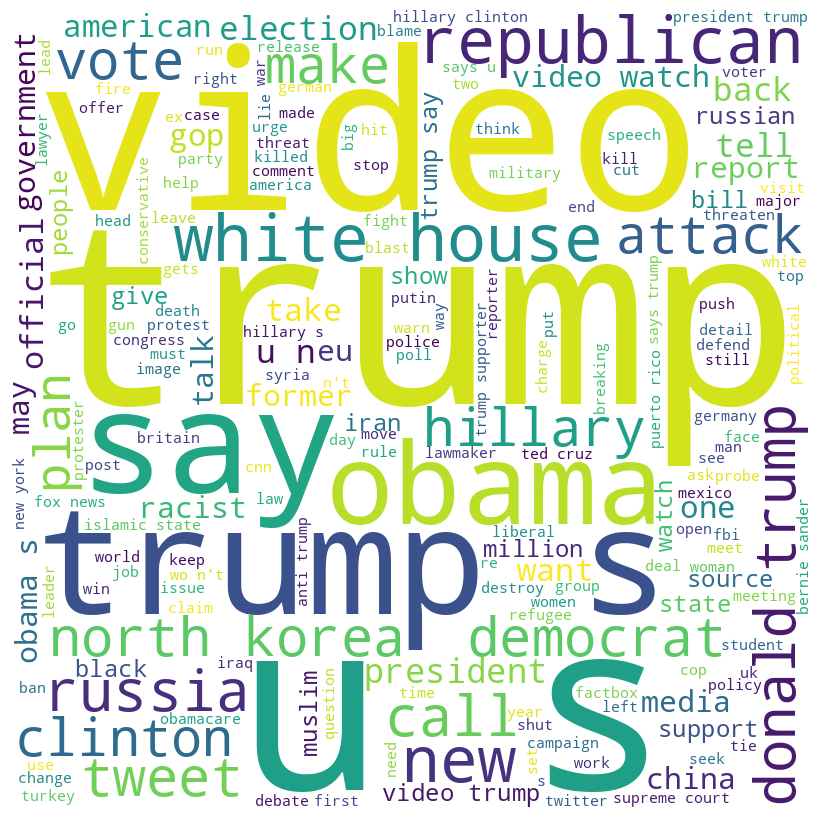

In [81]:
# Python program to generate WordCloud

# importing all necessary modules
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd

# Reads
df = data

comment_words = ''
stopwords = set(STOPWORDS)

# iterate through the csv file
for val in df.title:

    # typecaste each val to string
    val = str(val)

    # split the value
    tokens = val.split()

    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()

    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width=800, height=800,
                      background_color='white',
                      stopwords=stopwords,
                      min_font_size=10,
                      font_path=None).generate(comment_words)

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

In [82]:
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

from sklearn.feature_extraction.text import CountVectorizer

# Fonction pour obtenir les bigrammes les plus fréquents
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

# Obtenir les 20 bigrammes les plus fréquents
common_words = get_top_n_bigram(data['title'], 20)
for word, freq in common_words:
    print(word, freq)

white house 1040
donald trump 759
north korea 662
trump says 384
hillary clinton 352
supreme court 339
president trump 322
fox news 303
islamic state 236
trump video 233
ted cruz 224
bernie sanders 208
anti trump 192
puerto rico 190
new york 187
says trump 183
trump supporter 169
travel ban 168
president obama 165
trump campaign 163


<ipython-input-83-32d3efa0ca76>:28: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-83-32d3efa0ca76>:36: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




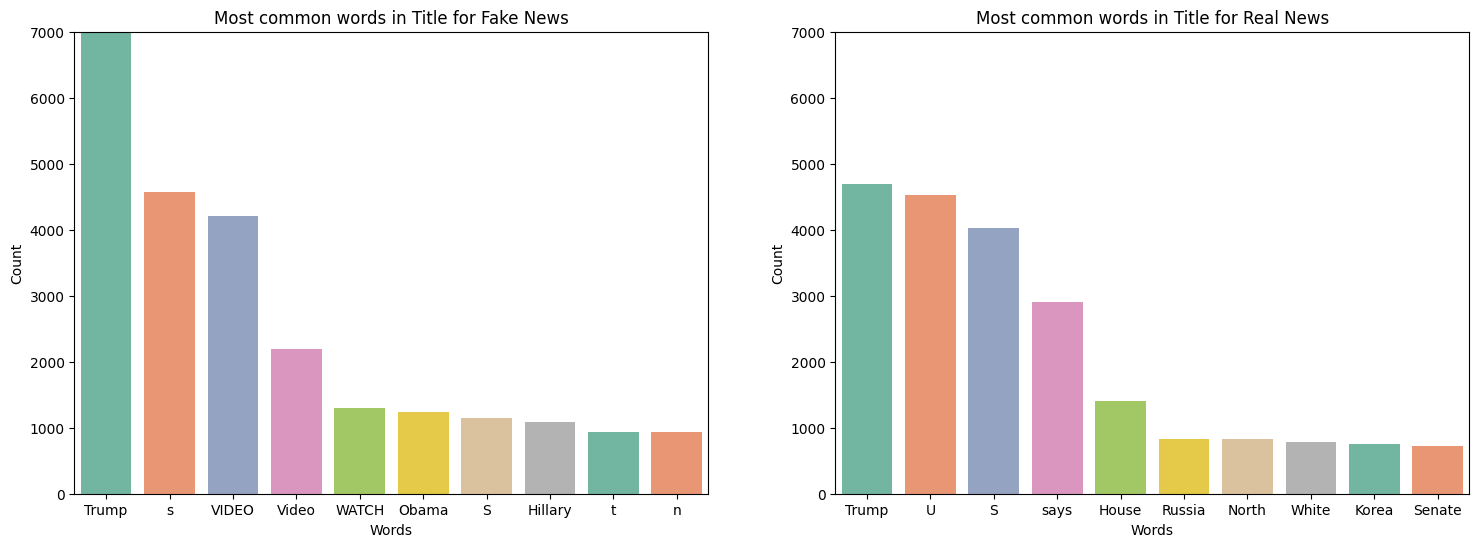

In [83]:
def get_wrd_count(text_lst):
    all_wrds = []
    tokenizer = RegexpTokenizer(r'\w+')
    for txt in text_lst:
        wrds = tokenizer.tokenize(txt)
        all_wrds.extend(wrds)
    wrd_counter = collections.Counter(all_wrds)
    return wrd_counter

fake_titles = data[data['fake']== 1]['title'].tolist()
real_titles = data[data['real']==1]['title'].tolist()

# word count

fake0_wrd = get_wrd_count(fake_titles)
real1_wrd = get_wrd_count(real_titles)

fake0_wrd_cnt_sorted = fake0_wrd.most_common(n=10)
real1_wrd_cnt_sorted = real1_wrd.most_common(n=10)
l0, h0, l1, h1 = [],[],[],[]
_ = [(l0.append(i[0]), h0.append(i[1])) for i in fake0_wrd_cnt_sorted]
_ = [(l1.append(i[0]), h1.append(i[1])) for i in real1_wrd_cnt_sorted]
#print(l1, h1)

colors = sns.color_palette("Set2", 10)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6));
sns.barplot(x=list(range(len(l0))), y=h0, ax=ax[0], palette=colors);
ax[0].set_ylim(top=7000);
ax[0].set_xticks(ticks = list(range(len(l0))));
ax[0].set_xticklabels(l0);
ax[0].set_xlabel('Words');
ax[0].set_ylabel('Count');
ax[0].set_title("Most common words in Title for Fake News");

sns.barplot(x=list(range(len(l1))), y=h1, ax=ax[1], palette=colors);
ax[1].set_ylim(top=7000);
ax[1].set_xticks(ticks = list(range(len(l1))));
ax[1].set_xticklabels(l1);
ax[1].set_xlabel('Words');
ax[1].set_ylabel('Count');
ax[1].set_title("Most common words in Title for Real News");

In [84]:
import pandas as pd
import numpy as np
from textblob import TextBlob, Word, Blobber

In [85]:
data['polarity'] = data['title'].map(lambda text: TextBlob(text).sentiment.polarity)

In [86]:
print(data.shape)

(38722, 7)


In [87]:
data.head(4)

,title,text,subject,date,real,fake,polarity
0,"'As U.S. budget fight looms , Republicans flip...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,2017-12-31,1,0,0.0
1,' U.S . military accept transgender recruits M...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,2017-12-29,1,0,-0.1
2,'Senior U.S. Republican senator : Let Mr. Muel...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,2017-12-31,1,0,0.0
3,'FBI Russia probe helped Australian diplomat t...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,2017-12-30,1,0,0.0


In [88]:
data = data[['text', 'subject', 'title','polarity', 'real','fake']]

In [89]:
data.head()

,text,subject,title,polarity,real,fake
0,WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"'As U.S. budget fight looms , Republicans flip...",0.0,1,0
1,WASHINGTON (Reuters) - Transgender people will...,politicsNews,' U.S . military accept transgender recruits M...,-0.1,1,0
2,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,'Senior U.S. Republican senator : Let Mr. Muel...,0.0,1,0
3,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,'FBI Russia probe helped Australian diplomat t...,0.0,1,0
4,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,'Trump wants Postal Service charge much Amazon...,0.2,1,0


In [90]:
data.fillna(value='', inplace=True)

In [91]:
import csv
data.to_csv("polarity_results.csv", index=False)

In [92]:
import numpy as np

data['polarity'] = np.asarray(data.polarity).astype(np.float32)

In [93]:
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Bidirectional, GRU, Dropout
from sklearn.model_selection import train_test_split

### Performing train test split

In [94]:
# text + metadata
train_split_fraction=0.8
split_index=int(number_of_samples*train_split_fraction)
data=data.sample(frac=1)
X_train,ytrain=data.iloc[:split_index,2], data.iloc[:split_index,4:]
X_test,ytest=data.iloc[split_index:,2], data.iloc[split_index:,4:]
X_Num_train,y_Numtrain=data.iloc[:split_index,[3]], data.iloc[:split_index,4:]
X_Num_test,y_Numtest=data.iloc[split_index:,[3]], data.iloc[split_index:,4:]

In [95]:
split_index

30977

In [96]:
data.head(5)

,text,subject,title,polarity,real,fake
27161,Republicans have pessimistically said it can t...,News,"' Sorry , GOP : Economic Powerhouse Got 99 % E...",-0.150000,0,1
26987,"According to Donald Trump, Joe The Plumber was...",News,' Trump Promised Pick White Man VP Reason Make...,-0.357143,0,1
12365,STOCKHOLM (Reuters) - Three people were arrest...,worldnews,'Swedish PM condemns attempted arson attack sy...,0.000000,1,0
33245,Trump began a more targeted outreach to Cathol...,politics,`` NUMBERS : 's Catholics Voted Historic Elect...,0.000000,0,1
32658,https://www.youtube.com/watch?v=9LNyx_DWzzA,politics,"' THANK BABY ... YES , FEMINISTS GO NUTS : Pre...",0.000000,0,1


In [97]:
print(data.shape)

(38722, 6)


In [98]:
# find the length of the largest sentence in training data
max_len = X_train.apply(lambda x: len(x)).max()
print(f'Max number of words in a text in training data: {max_len}')

Max number of words in a text in training data: 273


In [99]:
X_train.head(3)

,title
27161,"' Sorry , GOP : Economic Powerhouse Got 99 % E..."
26987,' Trump Promised Pick White Man VP Reason Make...
12365,'Swedish PM condemns attempted arson attack sy...


In [100]:
ytrain.head(3)

,real,fake
27161,0,1
26987,0,1
12365,1,0


In [101]:
X_test.head(3)

,title
26354,' School Required Teachers Call Police Student...
4982,'More states seek halt Trumps new travel ban c...
22692,`` Former SNL Cast Member Breaks Silence Trump...


In [102]:
ytest.head (3)

,real,fake
26354,0,1
4982,1,0
22692,0,1


In [103]:
X_Num_train.head(3)

,polarity
27161,-0.150000
26987,-0.357143
12365,0.000000


In [104]:
y_Numtrain.head(3)

,real,fake
27161,0,1
26987,0,1
12365,1,0


In [105]:
X_Num_test.head(3)

,polarity
26354,0.000000
4982,0.318182
22692,0.000000


In [106]:
y_Numtest.head(3)

,real,fake
26354,0,1
4982,1,0
22692,0,1


In [107]:
X_Num_train

,polarity
27161,-0.150000
26987,-0.357143
12365,0.000000
33245,0.000000
32658,0.000000
...,...
33467,-0.050000
18959,0.700000
35338,0.000000
32505,-0.075000


In [108]:
X_Num_test

,polarity
26354,0.000000
4982,0.318182
22692,0.000000
4502,0.000000
16419,-0.500000
...,...
23802,-0.100000
8992,0.000000
33663,-0.200000
10956,0.000000


#### Defining constants for padding, size of vocabulary

In [109]:
vocab_size = 10000
oov_token = "<OOV>"
max_length = 300
padding_type = "post"
trunction_type="post"

In [110]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(X_train)

In [111]:
print(tokenizer.num_words)

10000


# Word Indexing:The most frequent word would have index=1 and so on...

In [112]:
word_index = tokenizer.word_index
print(word_index)

{'<OOV>': 1, "'": 2, 'trump': 3, 'video': 4, "''": 5, "'s": 6, 'u': 7, 's': 8, 'says': 9, "'trump": 10, 'obama': 11, 'house': 12, 'hillary': 13, 'watch': 14, 'new': 15, 'president': 16, 'clinton': 17, 'white': 18, 'bill': 19, "n't": 20, 'state': 21, 'russia': 22, 'election': 23, 'court': 24, 'korea': 25, 'north': 26, 'republican': 27, 'donald': 28, 'calls': 29, 'vote': 30, 'news': 31, 'tax': 32, 'gop': 33, 'campaign': 34, 'republicans': 35, 'black': 36, 'deal': 37, 'media': 38, 'police': 39, 'senate': 40, 'may': 41, 'tweets': 42, 'gets': 43, 'anti': 44, 'one': 45, 'n': 46, 'party': 47, 'government': 48, 'talks': 49, 'attack': 50, 'america': 51, 'people': 52, 'first': 53, 'law': 54, 'minister': 55, 'plan': 56, 'twitter': 57, 'chief': 58, 'leader': 59, 'back': 60, 'muslim': 61, "'obama": 62, 'iran': 63, 'russian': 64, 'war': 65, 'could': 66, 'pm': 67, 'security': 68, 'ban': 69, 'tells': 70, 'right': 71, 'democrats': 72, 'would': 73, 'congress': 74, 'fbi': 75, 'speech': 76, 'trumps': 77, 

In [113]:
X_train_sequences = tokenizer.texts_to_sequences(X_train)
print(X_train_sequences)

[[2, 2293, 33, 722, 8568, 242, 4180, 665, 5856, 665, 2], [2, 3, 3169, 223, 18, 93, 704, 409, 94, 900, 2], [3689, 67, 994, 3510, 6501, 50, 1, 424, 275, 2], [1511, 6, 6502, 1161, 1476, 23, 5], [2, 4181, 1061, 2211, 5857, 146, 1891, 16, 3, 759, 1, 6503, 627, 519, 4181, 76, 4, 2], [3033, 2482, 486, 1, 1017, 1242, 2483, 4902, 2], [243, 7, 8, 3170, 22, 81, 679, 572, 481, 2794, 2], [8569, 230, 1018, 1633, 60, 1, 713, 553, 1335, 7, 8, 454, 230, 2], [341, 1512, 1185, 91, 279, 1216, 4903, 2294, 2], [82, 152, 119, 4182, 1336, 3, 6, 1, 808, 2, 1547, 809, 4, 5], [7396, 499, 389, 1122, 2795, 848, 2150, 2796, 885, 2], [8570, 1302, 6504, 1, 1, 3511, 447, 2], [2, 5858, 738, 194, 236, 2], [7397, 343, 1217, 1, 2919, 8571, 1, 4904, 2], [3331, 3034, 5365, 3, 2295, 1337, 1, 886, 2], [2, 7, 8, 1338, 511, 1962, 365, 173, 3035, 3332, 2], [3913, 16, 385, 244, 2484, 153, 1836, 3171, 63, 2], [2, 14, 5859, 6505, 102, 6506, 770, 1139, 3914, 1339, 606, 3172, 4, 2], [471, 3036, 8572, 1270, 798, 39, 2387, 1730, 238, 2

In [114]:
X_train_padded = pad_sequences(X_train_sequences,maxlen=max_length, padding=padding_type,
                       truncating=trunction_type)

In [115]:
print(X_train_padded.shape)

(30977, 300)


In [116]:
# data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler

# fit scaler on training data
norm = MinMaxScaler().fit(X_Num_train)

# transform training data
X_Num_train_norm = norm.transform(X_Num_train)

# transform testing dataabs
X_Num_test_norm = norm.transform(X_Num_test)

In [117]:
print(X_Num_train_norm.shape)


(30977, 1)


In [118]:
print('text example:', X_train[600])
print('sequence of indices(before padding):', X_train_sequences[220])
print('sequence of indices(after padding):', X_train_padded[220])


text example: 'Gulf carriers may focus foreign airline U.S. tax exemption cut '
sequence of indices(before padding): [1167, 300, 3927, 59, 1, 3352, 1, 2]
sequence of indices(after padding): [1167  300 3927   59    1 3352    1    2    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    

In [119]:
X_test_sequences = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_sequences,maxlen=max_length,
                               padding=padding_type, truncating=trunction_type)
X_test_padded

array([[   2,  230, 7377, ...,    0,    0,    0],
       [1684,  169,  304, ...,    0,    0,    0],
       [ 110, 1362, 2759, ...,    0,    0,    0],
       ...,
       [ 718,  637, 3325, ...,    0,    0,    0],
       [ 202,  468,    1, ...,    0,    0,    0],
       [3913,   61, 3463, ...,    0,    0,    0]], dtype=int32)

In [120]:
X_Num_train_norm= X_Num_train_norm.astype(np.float32)
X_Num_train_norm


array([[0.425     ],
       [0.32142857],
       [0.5       ],
       ...,
       [0.5       ],
       [0.4625    ],
       [0.5       ]], dtype=float32)

In [121]:
X_Num_test_norm= X_Num_test_norm.astype(np.float32)
X_Num_test_norm

array([[0.5      ],
       [0.6590909],
       [0.5      ],
       ...,
       [0.4      ],
       [0.5      ],
       [0.35     ]], dtype=float32)

### Using Glove  Embedding

In [122]:
import numpy as np

from google.colab import drive
import zipfile

# Monter Google Drive
drive.mount('/content/drive')

# Définir le chemin vers le fichier ZIP
zip_file_path = "/content/drive/MyDrive/glove.840B.300d.zip"

# Extraire le fichier ZIP
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall("/content/glove")

# Définir le chemin vers le fichier GloVe extrait
local_path = "/content/glove/glove.840B.300d.txt"

embeddings_index = {}

# Open the local file for reading
with open(local_path, encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = ''.join(values[:-300])
        coefs = np.asarray(values[-300:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 2195893 word vectors.


In [123]:
#see the vectors of Islamophobia
embeddings_index.get("Islamophobia")[:5]

array([-1.0639  ,  0.17925 ,  0.052323,  0.40803 ,  1.0349  ],
      dtype=float32)

In [124]:
embeddings_index.get("islamophobia")[:5]

array([-0.66834 , -0.020248, -0.35246 ,  0.11967 ,  0.62049 ],
      dtype=float32)

In [125]:
from scipy import spatial
spatial.distance.cosine(embeddings_index["hate"],embeddings_index["love"])

0.36069006020654604

In [126]:
embedding_matrix = np.zeros((len(word_index) + 1, max_length))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [127]:
#initialize the embedding_matrix with zeros
if vocab_size is not None:
    vocab_len = vocab_size
else:
    vocab_len = len(word_index)+1
embedding_matrix = np.zeros((vocab_len, max_length))
oov_count = 0
oov_words = []
for word, idx in word_index.items():
    if idx < vocab_len:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector
        else:
            oov_count += 1
            oov_words.append(word)

In [128]:
#print some of the out of vocabulary words
print(f'Some out of valubulary words: {oov_words[0:50]}')

Some out of valubulary words: ['<OOV>', "'trump", "'obama", 'brexit', "'factbox", "'breaking", "'white", "'senate", "'house", "'china", "'trumps", "'watch", "'clinton", "'republican", "'russia", "'new", "'the", "'exclusive", "'turkey", "'in", "'south", "'eu", 'rohingya', "'uk", 'tillerson', "'german", "'former", "'saudi", "'russian", "'wow", "'north", "'putin", "'top", "'iran", "'no", 'kellyanne', "'kremlin", "'democrats", "'britain", "'senator", "'mexico", "'syrian", "'hillary", "'boiler", "'tillerson", "'after", "'british", "'ex", "'merkel", "'republicans"]


In [129]:
print(f'{oov_count} out of {vocab_len} words were OOV.')

1232 out of 10000 words were OOV.


In [130]:
print(embedding_matrix)

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-2.62620002e-01  5.42450011e-01  7.14249983e-02 ...  1.39909998e-01
   1.85959991e-02 -1.80079998e-03]
 ...
 [ 3.44669998e-01  1.23140000e-01 -9.72120017e-02 ...  2.62970001e-01
  -4.31279987e-01 -2.51480000e-04]
 [ 3.49169999e-01 -2.36410007e-01 -1.41560003e-01 ...  5.22360027e-01
  -7.82060027e-02 -2.29790002e-01]
 [ 2.07080007e-01  3.15050006e-01 -1.98819995e-01 ... -2.77139992e-01
  -2.99780011e-01 -7.23780021e-02]]


In [131]:
print("embedding_matrix.shape:", embedding_matrix.shape)

embedding_matrix.shape: (10000, 300)


### Defining Embedding layer

In [132]:
embedding_matrix = np.zeros((len(word_index) + 1, 300))  # Adapter cette ligne
embedding_layer = Embedding(len(word_index) + 1,
                            max_length,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning:

Argument `input_length` is deprecated. Just remove it.



# Bi-LSTM Model

In [133]:
import tensorflow as tf
import keras

In [134]:
from keras.layers import Dense, Embedding, LSTM, Bidirectional, Input
from keras.models import Model
from keras.layers import concatenate
from keras.layers import BatchNormalization


In [135]:
from tensorflow.python.keras import regularizers

In [136]:
embedding_dim = 300

nlp_input = Input(shape=(max_length,), name='nlp_input')
meta_input = Input(shape=(1,), name='meta_input')

# Embedding layer
emb = Embedding(output_dim=embedding_dim, input_dim=len(word_index) + 1, input_length=max_length, trainable=True)(nlp_input)

# LSTM layers
nlp_out = Bidirectional(LSTM(256, return_sequences=True, dropout=0.2, kernel_regularizer=regularizers.l1_l2(l1=0.0001, l2=0.001)))(emb)
nlp_out = Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.1, kernel_regularizer=regularizers.l1_l2(l1=0.0001, l2=0.001)))(nlp_out)

# Concatenate metadata input
x = concatenate([nlp_out, meta_input])

# Dense layers with Dropout
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)

# Output layer
x = Dense(2, activation='sigmoid')(x)

# Compile model
model = Model(inputs=[nlp_input, meta_input], outputs=[x])

In [137]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ nlp_input (InputLayer)    │ (None, 300)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 300, 300)       │      6,847,200 │ nlp_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 300, 512)       │      1,140,736 │ embedding_1[0][0]      │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 256)            │        656,384 │ bidirectional[0][0]    │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ meta_input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 257)            │              0 │ bidirectional_1[0][0], │
│                           │                        │                │ meta_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 64)             │         16,512 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 64)             │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 2)              │            130 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 8,660,962 (33.04 MB)

 Trainable params: 8,660,962 (33.04 MB)

 Non-trainable params: 0 (0.00 B)

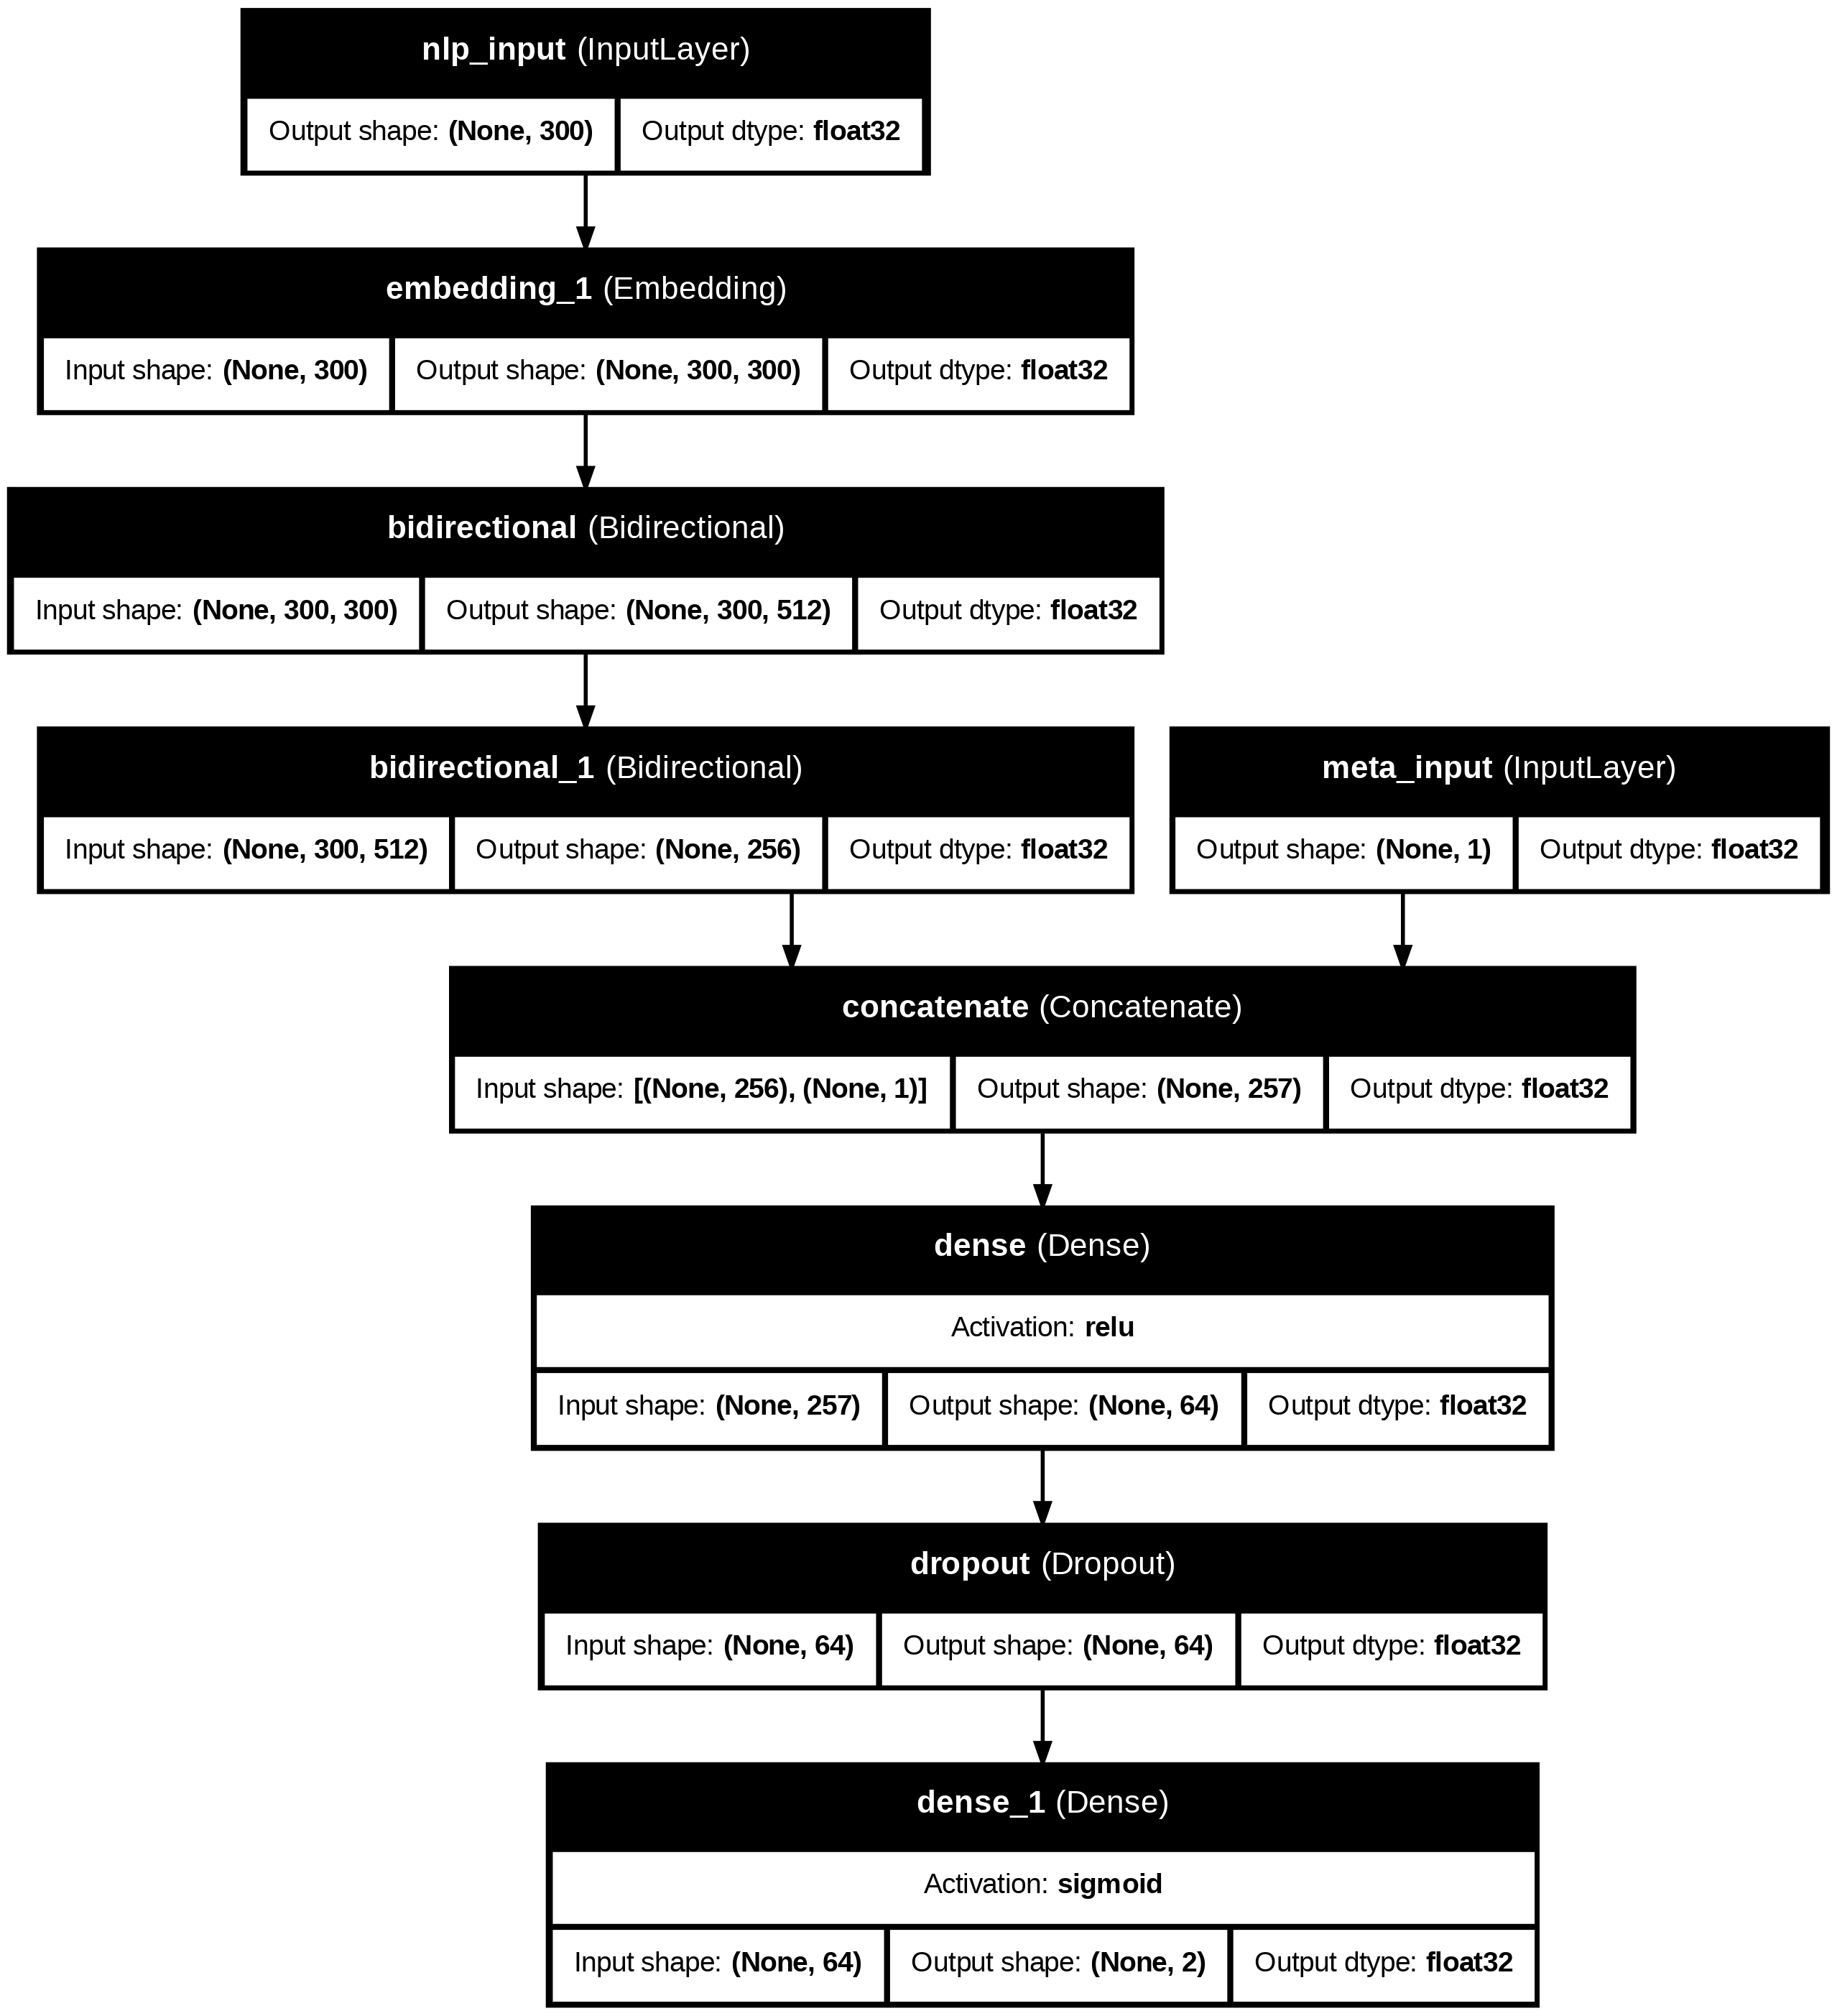

In [138]:
model_img_file = 'model.png'
tf.keras.utils.plot_model(model, to_file=model_img_file,
                          show_shapes=True,
                          show_layer_activations=True,
                          show_dtype=True,
                          show_layer_names=True )

In [139]:
%%time
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["AUC", "accuracy"])
history=model.fit([X_train_padded, X_Num_train_norm],[ytrain, y_Numtrain],batch_size = 512, epochs = 5, validation_data=([X_test_padded, X_Num_test_norm],[ytest,y_Numtest]))

Epoch 1/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - AUC: 0.8156 - accuracy: 0.7468 - loss: 4.4731 - val_AUC: 0.9903 - val_accuracy: 0.9644 - val_loss: 1.0475
Epoch 2/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - AUC: 0.9931 - accuracy: 0.9772 - loss: 0.7674 - val_AUC: 0.9969 - val_accuracy: 0.9813 - val_loss: 0.3771
Epoch 3/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - AUC: 0.9972 - accuracy: 0.9879 - loss: 0.3200 - val_AUC: 0.9961 - val_accuracy: 0.9733 - val_loss: 0.2725
Epoch 4/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - AUC: 0.9985 - accuracy: 0.9925 - loss: 0.2017 - val_AUC: 0.9905 - val_accuracy: 0.9712 - val_loss: 0.2365
Epoch 5/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - AUC: 0.9989 - accuracy: 0.9919 - loss: 0.1481 - val_AUC: 0.9949 - val_accuracy: 0.9778 - val_loss: 0.1684
CPU times: user 10min 11s, sys: 51.4 s, total: 11min 2s
Wall time: 11min 34s


In [140]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    auc = history.history['accuracy']
    val_auc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(auc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, auc, 'b', label='Training accuracy')
    plt.plot(x, val_auc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

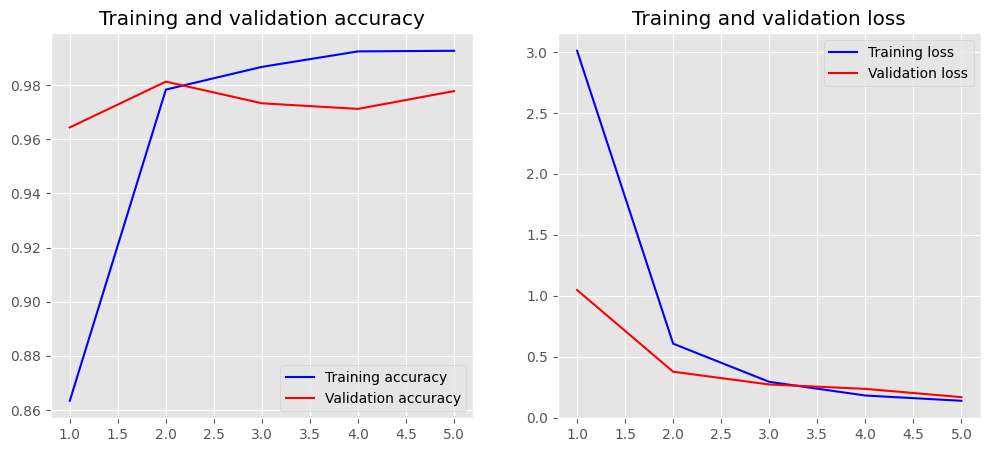

In [141]:
plot_history(history)

In [142]:
# Évaluer le modèle sur les données de test
test_loss, test_auc, test_accuracy = model.evaluate([X_test_padded, X_Num_test_norm], ytest)

# Afficher l'accuracy et l'AUC
print(f"Test AUC: {test_auc * 100:.4f}%")
print(f"Test Accuracy: {test_accuracy * 100:.4f}%")

243/243 ━━━━━━━━━━━━━━━━━━━━ 83s 340ms/step - AUC: 0.9956 - accuracy: 0.9784 - loss: 0.1623
Test AUC: 99.4887%
Test Accuracy: 97.6372%


243/243 ━━━━━━━━━━━━━━━━━━━━ 82s 333ms/step


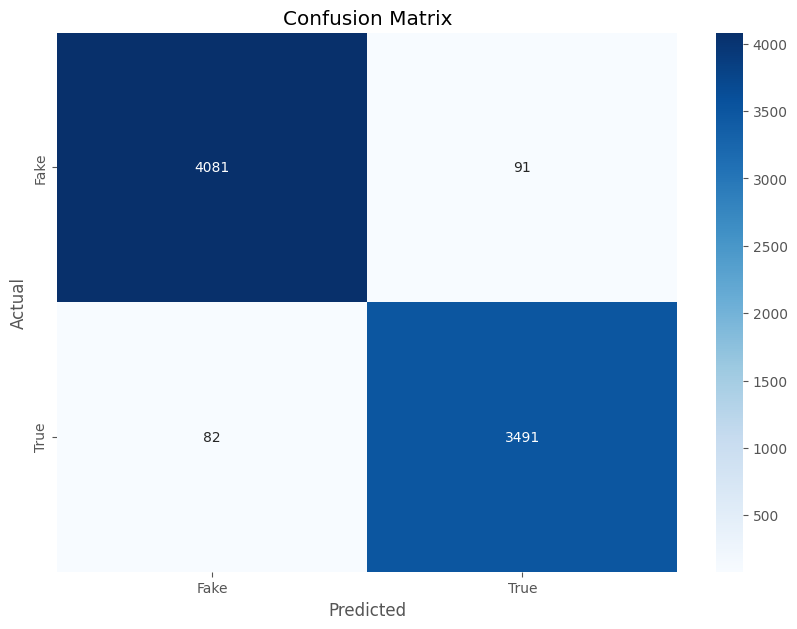

In [143]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import metrics

# Convertir ytest en tableau NumPy si c'est un DataFrame
ytest_np = ytest.to_numpy()

# Séparation des données de test
nlp_test = X_test_padded  # Les séquences de texte prétraitées
meta_test = X_Num_test_norm  # Les métadonnées normalisées

# Prédiction avec le modèle
y_pred = model.predict([nlp_test, meta_test])

# Convertir les prédictions en tableau NumPy
y_pred_np = np.array(y_pred)

# Créer la matrice de confusion
cm = metrics.confusion_matrix(ytest_np.argmax(axis=1), y_pred_np.argmax(axis=1))

def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Tracer la matrice de confusion
plot_confusion_matrix(cm, classes=['Fake', 'True'])


In [144]:
# Convert predicted probabilities to class labels
y_pred_np = np.argmax(y_pred_np, axis=1)  # Assuming your model outputs probabilities

# Ensure the true labels are in the same format (e.g., class labels, not one-hot encoded)
ytest_np = np.argmax(ytest_np, axis=1)  # If ytest_np is one-hot encoded, otherwise skip this

# Now you can generate the classification report
from sklearn.metrics import classification_report
print(classification_report(ytest_np, y_pred_np))


              precision    recall  f1-score   support

           0       0.98      0.98      0.98      4172
           1       0.97      0.98      0.98      3573

    accuracy                           0.98      7745
   macro avg       0.98      0.98      0.98      7745
weighted avg       0.98      0.98      0.98      7745



In [145]:
from sklearn.metrics import precision_score, recall_score, f1_score

print(f"Accuracy of Bi-LSTM model, {accuracy_score(ytest_np, y_pred_np) * 100:.4f}%")
print(f"Precision of Bi-LSTM model, {precision_score(ytest_np, y_pred_np) * 100:.4f}%")
print(f"Recall of Bi-LSTM model, {recall_score(ytest_np, y_pred_np) * 100:.4f}%")
print(f"F1_score of Bi-LSTM model, {f1_score(ytest_np, y_pred_np) * 100:.4f}%")


Accuracy of Bi-LSTM model, 97.7663%
Precision of Bi-LSTM model, 97.4595%
Recall of Bi-LSTM model, 97.7050%
F1_score of Bi-LSTM model, 97.5821%
